In [1]:
from google.colab import drive
import os
from PIL import Image, ImageDraw, ImageFont,ImageOps
from PIL.Image import open
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [2]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
path_to_zip = '/content/drive/My\ Drive/fast_ai/datasets/379764_737475_bundle_archive.zip'

In [4]:
! unzip -q {path_to_zip}

In [5]:
import cv2
from google.colab.patches import cv2_imshow

In [6]:
lists = os.listdir('/content/images/')
lists[:10]

['2099_2001.jpg',
 '12133_2005.jpg',
 '37584_2012.jpg',
 '48080_2014.jpg',
 '44564_2013.jpg',
 '53808_2016.jpg',
 '12522_2005.jpg',
 '44876_2014.jpg',
 '876_2000.jpg',
 '32158_2010.jpg']

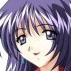

In [7]:
image = cv2.imread('/content/images/2099_2001.jpg')
cv2_imshow(image)
#print (image is not None)

In [35]:
path_color = Path('/content/images')
path_gray = Path('/content/gray')

True

In [9]:
class grayscaleConv(object):
  def __init__(self, path_gray, path_color):
    self.path_gray = path_gray
    self.path_color = path_color

  def __call__(self, fn, i):
    dest = self.path_gray/fn.relative_to(self.path_color)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    img = ImageOps.grayscale(img)
    img.save(dest)

In [10]:
imgl = ImageList.from_folder(path_color)

In [11]:
parallel(grayscaleConv(path_gray, path_color), imgl.items)

In [12]:
bs, size = 64, 120
arch = models.resnet34

In [13]:
src = ImageImageList.from_folder(path_gray).split_by_rand_pct(0.1, seed=42)

In [14]:
def get_data(bs, size):
  data = (src.label_from_func(lambda x: path_color/x.name)
  .transform(get_transforms(max_zoom=1.1), size=size, tfm_y=True)
  .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

  data.c = 3
  return data

In [15]:
data_gen = get_data(bs, size)

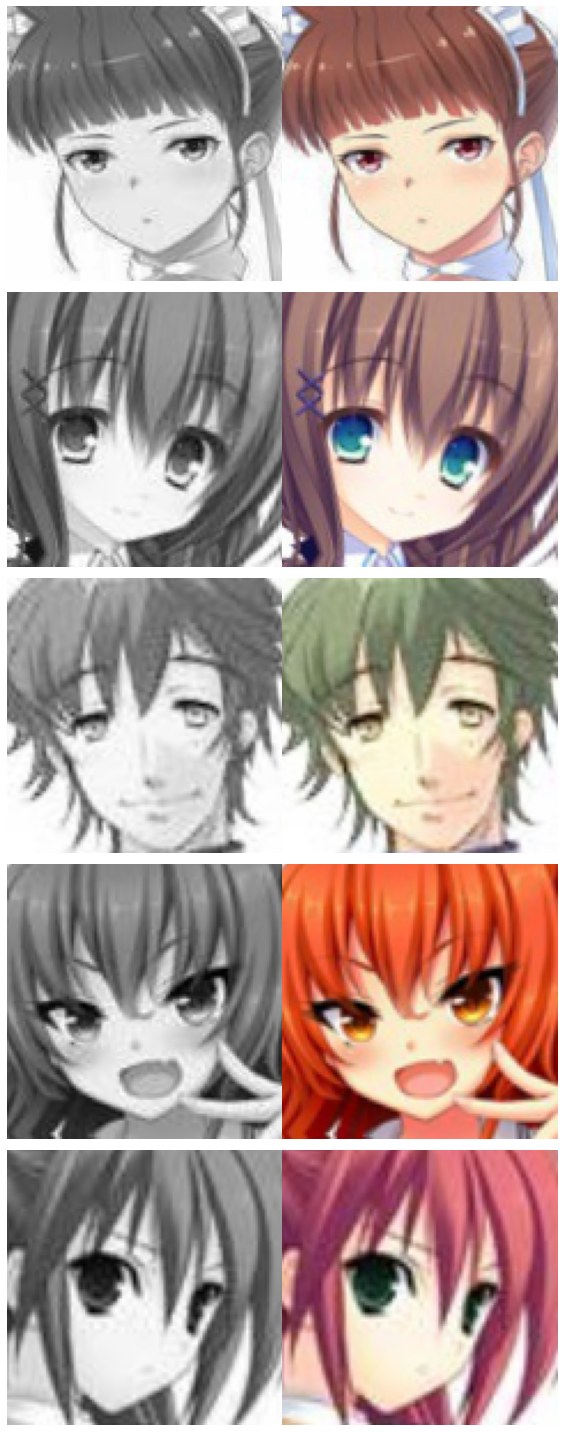

In [16]:
data_gen.show_batch(5)

In [17]:
wd = 1e-3

In [18]:
y_range = (-3., 3.)

In [19]:
loss_gen = MSELossFlat()

In [20]:
def create_gen_learner():
  return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [21]:
learn_gen = create_gen_learner()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

epoch,train_loss,valid_loss,time
0,0.128058,0.129811,12:18
1,0.120466,0.118385,12:04


In [ ]:
learn_gen.unfreeze()

In [ ]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

epoch,train_loss,valid_loss,time
0,0.120211,0.117286,12:43
1,0.114196,0.113109,12:43
2,0.112799,0.111093,12:44


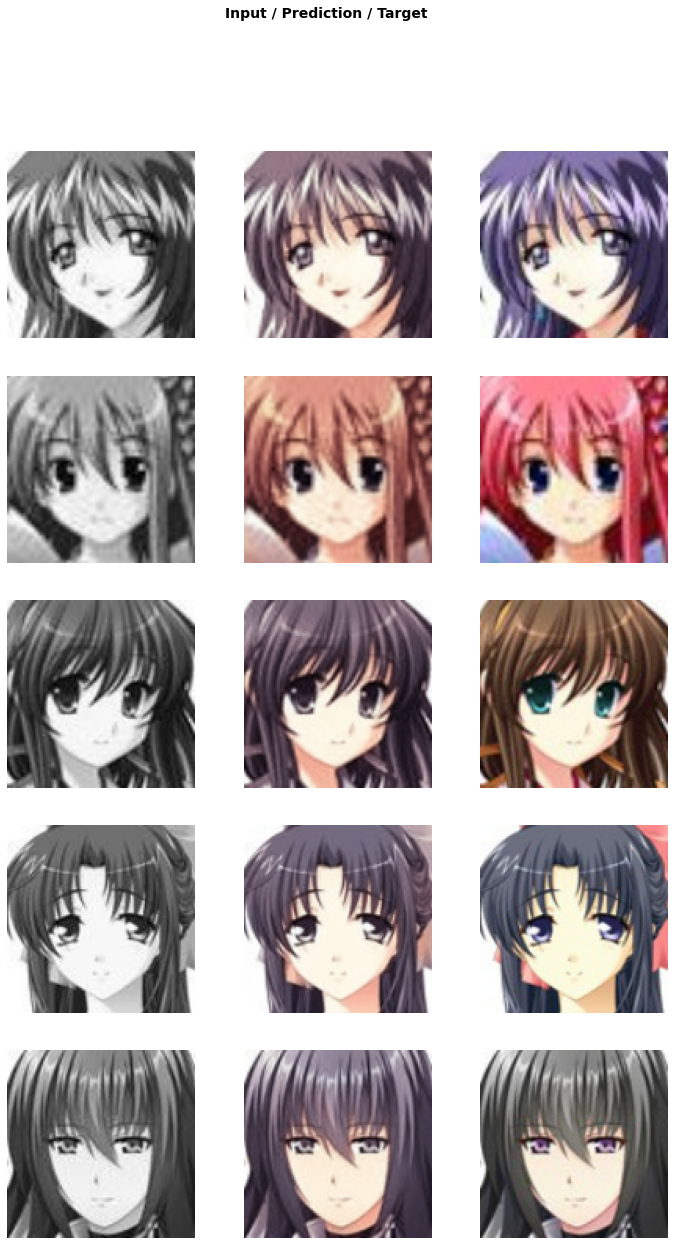

In [ ]:
learn_gen.show_results(2)

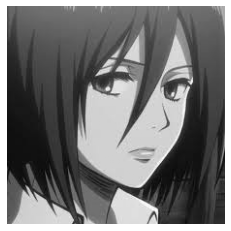

In [43]:
test_img = open_image('/content/mikasa.jpg')
test_img.show(figsize=(4,4))

In [44]:
pred = learn_gen.predict(test_img)

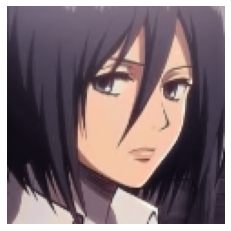

In [45]:
show_image(pred[0], figsize=(4,4))

In [ ]:
learn_gen.path = Path('/content')

In [ ]:
learn_gen.path

PosixPath('/content')

In [ ]:
learn_gen.save('gen-2')

In [ ]:
learn_gen.export('color-using-unet.pkl')

## **Save Generated Images**

In [36]:
path_to_pkl = Path('/content/drive/My\ Drive/fast_ai/export_files/export.pkl')

In [37]:
path = Path('/content/')

In [38]:
! cp {path_to_pkl} {path}

In [39]:
learn_gen = load_learner(path, 'export.pkl')

In [46]:
name_gen = 'gen_images'
path_gen = path/name_gen

In [47]:
path_gen.mkdir(exist_ok=True)

In [48]:
def save_predictions(dl):
  i=0
  names = dl.dataset.items

  for b in dl:
    preds = learn_gen.pred_batch(batch=b, reconstruct=True)
    for o in preds:
      o.save(path_gen/names[i].name)
      i += 1

In [49]:
save_predictions(data_gen.fix_dl)

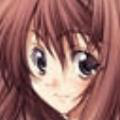

In [53]:
PIL.Image.open(path_gen.ls()[101])

## **Train Discriminator**

In [54]:
learn_gen = None
gc.collect()

427

In [58]:
def get_critic_data(classes, bs, size):
  src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
  ll = src.label_from_folder(classes=classes)
  data = (ll.transform(get_transforms(max_zoom=1.5), size=size)
          .databunch(bs=bs).normalize(imagenet_stats))
  data.c = 3
  return data

In [59]:
data_critic = get_critic_data([name_gen, 'images'], bs=bs, size=size)

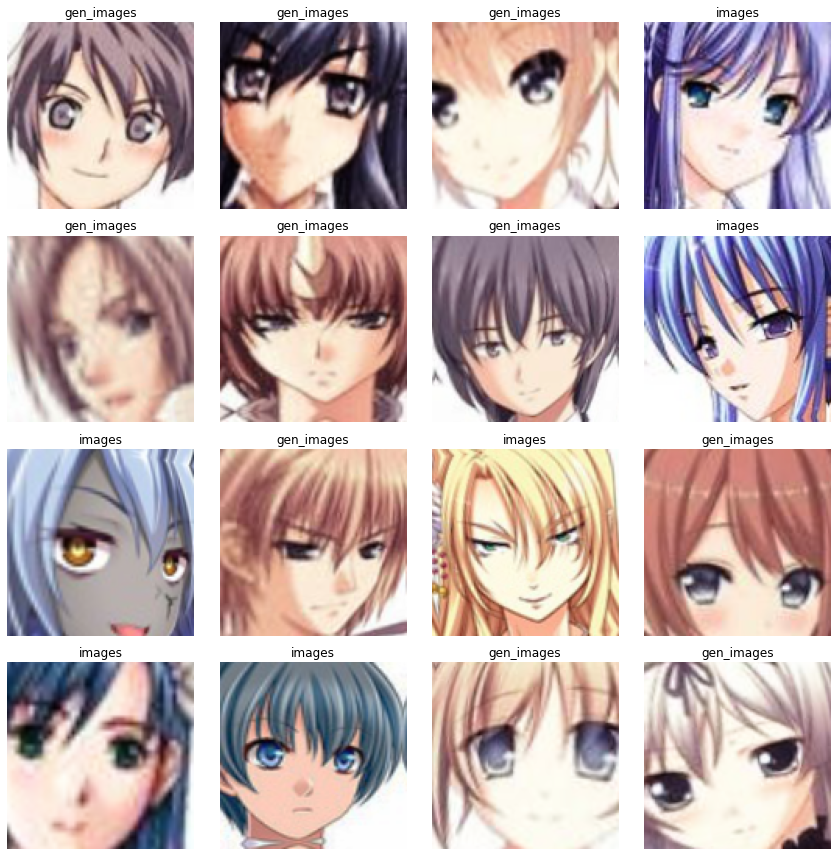

In [60]:
data_critic.show_batch(rows=4, ds_type = DatasetType.Train, imgsize=3)

In [61]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [62]:
def critic_learner(data, metric):
  return Learner(data, gan_critic(), metrics=metric, loss_func=loss_critic, wd=wd)

In [63]:
learn_critic = critic_learner(data_critic, accuracy_thresh_expand)

In [65]:
learn_critic.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.069751,0.065198,0.975830,51:21
1,0.019284,0.011628,0.996739,50:48
2,0.014274,0.010217,0.996807,50:05
3,0.004596,0.005564,0.998018,50:02


In [67]:
learn_critic.save('critic')

In [68]:
learn_critic.export('export_critic.pkl')

## **GAN**

In [69]:
path_to_critic = '/content/export_critic.pkl'
path_to_store = '/content/drive/My\ Drive/fast_ai/export_files/'

In [70]:
! cp {path_to_critic} {path_to_store}